# Cognitive scores 10-fold experiments


In [1]:
import os
import math
from random_slope_model import RandomSlopeModel, load_model
import numpy as np
import torch
import pickle as pickle
from longitudinal_image_dataset import LongitudinalImageDataset, load_image_dataset
from longitudinal_scalar_dataset import LongitudinalScalarDataset, load_scalar_dataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import csv
from utils import plot_normal_density
%matplotlib inline  
from scipy.stats import mannwhitneyu

pval_threshold = 0.1


def load_output_dir(output_dir):
    try:
        import os
        import sys
        original_out = sys.stdout
        f = open(os.devnull, 'w')
        sys.stdout = f

        train_residuals = np.loadtxt(os.path.join(output_dir, 'train_residuals.txt'))
        test_residuals = np.loadtxt(os.path.join(output_dir, 'test_residuals.txt'))

        train_latent_positions = np.loadtxt(os.path.join(output_dir, 'train_latent_positions.txt'))
        test_latent_positions = np.loadtxt(os.path.join(output_dir, 'test_latent_positions.txt'))

        train_latent_trajectories = np.loadtxt(os.path.join(output_dir, 'train_latent_trajectories.txt'))
        test_latent_trajectories = np.loadtxt(os.path.join(output_dir, 'test_latent_trajectories.txt'))

        model = load_model(os.path.join(output_dir, 'model'))
        train_dataset = load_scalar_dataset(os.path.join(output_dir, 'train_dataset.p'))
        test_dataset = load_scalar_dataset(os.path.join(output_dir, 'test_dataset.p'))

        sys.stdout = original_out
        return model, train_dataset, test_dataset, train_residuals, test_residuals, \
                train_latent_positions, test_latent_positions, train_latent_trajectories, test_latent_trajectories
    except:
        sys.stdout = original_out

def mann_whitney_test(values, labels):
    values_pos = np.extract(labels, values)
    values_neg = np.extract(1.-labels, values)
    stat, pval = mannwhitneyu(values_pos, values_neg)
    return pval, np.mean(values_pos), np.mean(values_neg)


def get_info_for_dataset(dataset, field_name, conversion=lambda x: int(x)):         
    dico = {}

    with open('ADNIMERGE.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row[field_name] != '':
                dico[float(row['RID'])] = conversion(row[field_name])

    field_dataset = []

    for rid in train_dataset.times_per_id.keys():
        field_dataset.append(dico[rid])
        if field_name == 'AGE':
            if abs(float(dataset.ages_per_id[rid][0]) - dico[rid]) > 0.01:
                print('OUPS rid {} {} vs {}'\
                .format(rid, float(dataset.ages_per_id[rid][0]), dico[rid]))

    return np.array(field_dataset)


In [13]:
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

train_mses_mean = np.zeros(len(test_sizes))
test_mses_mean = np.zeros(len(test_sizes))

train_mses_std = np.zeros(len(test_sizes))
test_mses_std = np.zeros(len(test_sizes))


for i, test_size in enumerate(test_sizes):
    train_mses_test_size = []
    test_mses_test_size = []
    
    for fold_number in range(10):
        output_dir = "../output_adas/output_test_{}_fold_{}".format(test_size, fold_number)
        
        if os.path.isdir(output_dir):
            #print(output_dir)
            model, train_dataset, test_dataset, train_residuals, test_residuals, \
                train_lp, test_pl = load_output_dir(output_dir)
            
            train_mses_test_size.append(np.mean(train_residuals))
            test_mses_test_size.append(np.mean(test_residuals))
                
    train_mses_mean[i] = np.mean(train_mses_test_size)
    test_mses_mean[i] = np.mean(test_mses_test_size)
    
    train_mses_std[i] = np.std(train_mses_test_size)
    test_mses_std[i] = np.std(test_mses_test_size)

train_sizes = (1.- np.array(test_sizes)) * len(train_dataset)
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mses_mean, label='Train mse', c='b')
plt.plot(train_sizes, test_mses_mean, label='Test mse', c='g')

plt.fill_between(train_sizes, train_mses_mean - train_mses_std, train_mses_mean + train_mses_std, alpha=0.2, color='b')
plt.fill_between(train_sizes, train_mses_mean - test_mses_std, test_mses_mean + test_mses_std, alpha=0.2, color='g')


plt.legend(prop={'size': 15})
plt.xlabel('Training set size', fontsize=25)
plt.ylabel('Mean Squared Error', fontsize=25)
plt.tight_layout()
plt.savefig('../Figures/cognitive_scores_varying_test_size.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

TypeError: 'NoneType' object is not iterable

# Varying number of observations per subject

/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


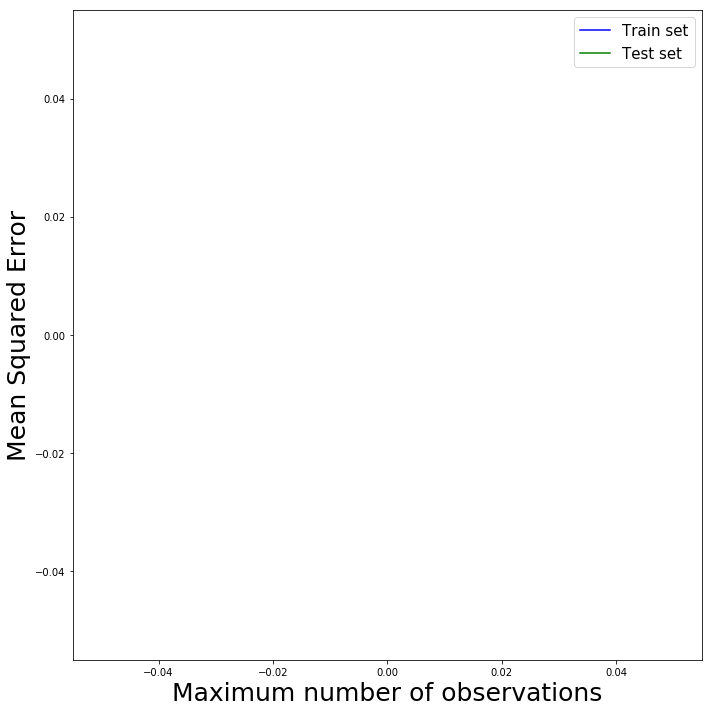

In [2]:
obs_numbers = [2, 3, 4, 5, 6]
train_mses = []
test_mses = []

train_mses_mean = np.zeros(len(obs_numbers))
test_mses_mean = np.zeros(len(obs_numbers))

train_mses_std = np.zeros(len(obs_numbers))
test_mses_std = np.zeros(len(obs_numbers))

for i, obs_number in enumerate(obs_numbers):
    train_mses_obs_number = []
    test_mses_obs_number = []
    
    for fold_number in range(10):
        output_dir = "../output_adas/output_nb_obs_{}_fold_{}".format(obs_number, fold_number)
        if os.path.isdir(output_dir):
            #print(output_dir)
            model, train_dataset, test_dataset, train_residuals, test_residuals, \
                train_lp, test_pl = load_output_dir(output_dir)

            train_mses_obs_number.append(np.mean(train_residuals))
            test_mses_obs_number.append(np.mean(test_residuals))
                
    train_mses_mean[i] = np.mean(train_mses_obs_number)
    test_mses_mean[i] = np.mean(test_mses_obs_number)
                
    train_mses_std[i] = np.std(train_mses_obs_number)
    test_mses_std[i] = np.std(test_mses_obs_number)

plt.figure(figsize=(10, 10))
plt.plot(obs_numbers, train_mses_mean, label='Train set', c='b')
plt.plot(obs_numbers, test_mses_mean, label='Test set', c='g')
plt.fill_between(obs_numbers, train_mses_mean - train_mses_std, train_mses_mean + train_mses_std, alpha=0.2, color='b')
plt.fill_between(obs_numbers, test_mses_mean - test_mses_std, test_mses_mean + test_mses_std, alpha=0.2, color='g')

plt.legend(prop={'size': 15})
plt.xlabel('Maximum number of observations', fontsize=25)
plt.ylabel('Mean Squared Error', fontsize=25)
plt.tight_layout()
plt.savefig('../Figures/cognitive_scores_varying_nb_obs.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# Experiments with varying l

In [14]:
l = [0., 0.1, 1.]
for l in l:
    output_dir = '../output_adas/output_l_{}'.format(l)
    print(output_dir)
    model, train_dataset, test_dataset, train_residuals, test_residuals, train_lp, test_lp = load_output_dir(output_dir)
    
    apoe_dataset = get_info_for_dataset(train_dataset, 'APOE4', conversion=lambda x:0 if int(x)==0 else 1)
    gender_dataset = get_info_for_dataset(train_dataset, 'PTGENDER', conversion=lambda x:0 if x == 'Male' else 1)
    #age_dataset = get_info_for_dataset(train_dataset, 'AGE', conversion=lambda x:float(x))
       
    pca = PCA(n_components=2)
    projected_lp = pca.fit_transform(train_lp)

    figsize = (5, 5)
    
    for (name, labels) in zip(["apoe", "gender"], [apoe_dataset, gender_dataset]):
        plt.figure(figsize=figsize)
        #plt.xlim(-3, 3)
        #plt.ylim(-3, 3)
        plot_normal_density(-3, 3., -3., 3.)
        plt.scatter(train_lp[:, 0], train_lp[:, 2], c=labels)
        plt.title('Latent position vs {}'.format(name), fontsize=20)
        plt.tight_layout()
        plt.show()

        for i in range(model.encoder_dim):
            pval = mann_whitney_test(train_lp[:, i], apoe_dataset)
            if pval < pval_threshold:
                print('\nPVALUE for {} {} {}'.format(i, name, pval))

    # Plotting with the extra informations:

../output_adas/output_l_0.0


TypeError: 'NoneType' object is not iterable

In [ ]:
output_dir = '../output_adas/output_uniform_sampler_fold_0'
print(output_dir)
model, train_dataset, test_dataset, train_residuals, test_residuals, train_lp, test_lp = load_output_dir(output_dir)   

plot_normal_density(-3,3,-3,3)
plt.scatter(train_lp[:, 0], train_lp[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.scatter(test_lp[:, 0], test_lp[:, 1])
plt.show()

# Variational experiments

/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


-0.472473651171 1.63094711304


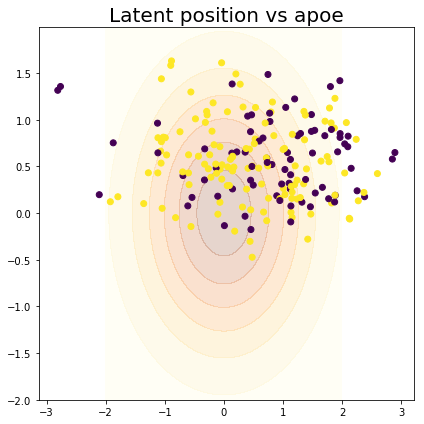

0.00102414880254

PVALUE for 0 apoe 0.0010241488025407965, 0.4198605095952507 vs 0.8189939988123907
0.0383599970021

PVALUE for 1 apoe 0.0383599970021487, -0.0017847914884730083 vs 0.031537012330123355
0.235586856455
-0.472473651171 1.63094711304


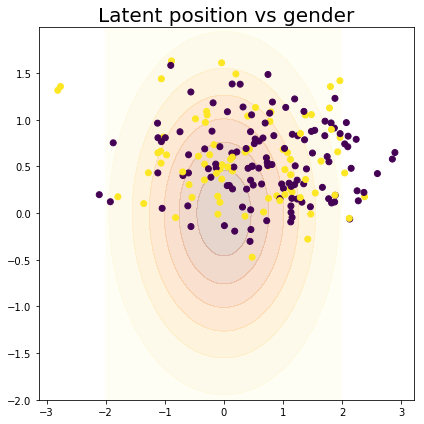

0.0111069365221

PVALUE for 0 gender 0.01110693652211865, 0.3476357267627233 vs 0.7210095716902047
0.359471181147
0.395540836122


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.0673332810402 2.05774331093


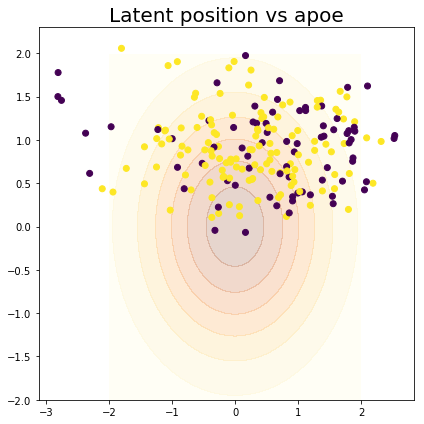

0.00113109197075

PVALUE for 0 apoe 0.0011310919707517714, 0.22780032181739807 vs 0.5843263804912567
0.0517973148263

PVALUE for 1 apoe 0.0517973148262551, 0.005818517118692398 vs 0.042455918043851855
0.319400828253
-0.0673332810402 2.05774331093


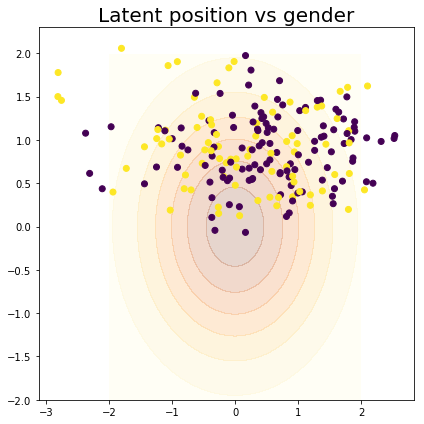

0.00320392734363

PVALUE for 0 gender 0.003203927343632548, 0.10020666914742167 vs 0.543072643168902
0.227703822778
0.40913667276


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.29485976696 1.67311692238


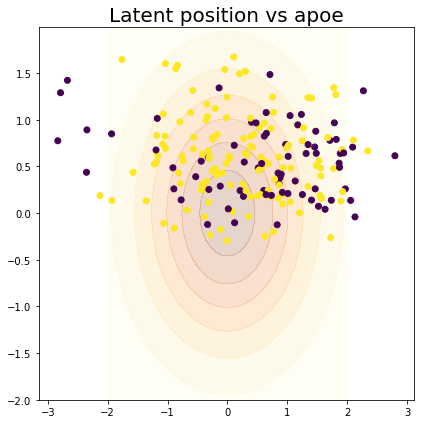

0.00109591947625

PVALUE for 0 apoe 0.0010959194762499434, 0.20624571058928498 vs 0.5645505416474931
0.0452655181765

PVALUE for 1 apoe 0.04526551817650977, -0.00016212287380939393 vs 0.03492891380231675
0.34610002592
-0.29485976696 1.67311692238


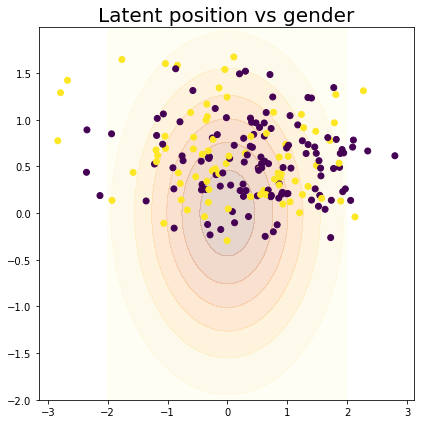

0.0074122597179

PVALUE for 0 gender 0.007412259717895316, 0.0980287995896762 vs 0.49306710427703937
0.287807277748
0.310361859808


OUPS rid 729.0 65.65890502929688 vs 65.1
0.0294395834208 2.23324275017


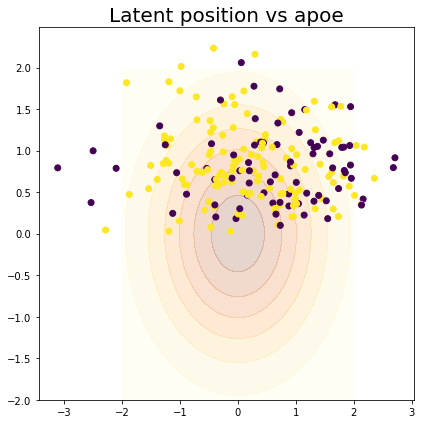

0.00105409918528

PVALUE for 0 apoe 0.0010540991852828088, 0.18985238826274872 vs 0.5978574839077497
0.0565783613431

PVALUE for 1 apoe 0.05657836134309329, 0.017347612857818603 vs -0.013004870791184274
0.36079192656
0.0294395834208 2.23324275017


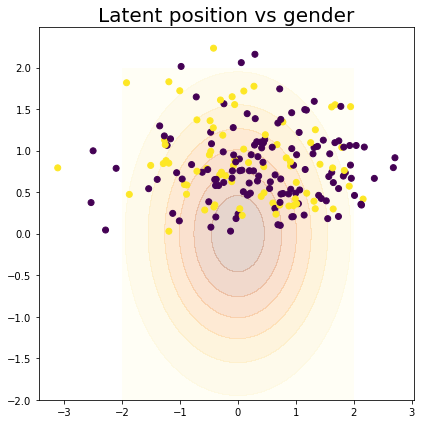

0.012746363409

PVALUE for 0 gender 0.012746363409017612, 0.12764175598685806 vs 0.4702616328094888
0.406099369284
0.219728090093


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.580725193024 1.46377778053


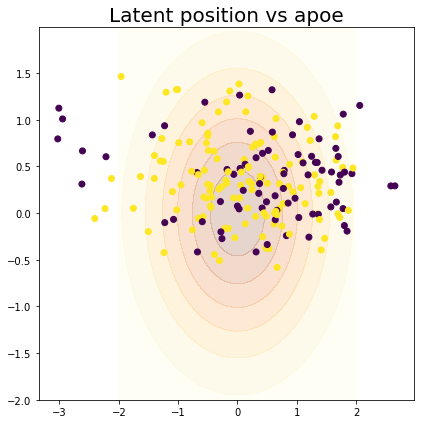

0.000953880754268

PVALUE for 0 apoe 0.0009538807542676714, 0.08008654866247408 vs 0.44840007304371177
0.111045263773
0.275953717532
-0.580725193024 1.46377778053


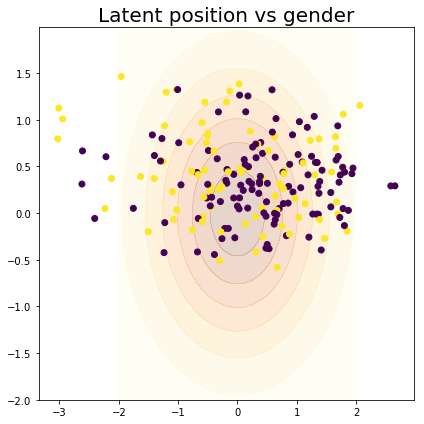

0.00415934306865

PVALUE for 0 gender 0.004159343068653591, -0.029699006912911812 vs 0.39405761533925515
0.276455798186
0.176453523721


OUPS rid 729.0 65.65890502929688 vs 65.1
0.18304798007 2.20810127258


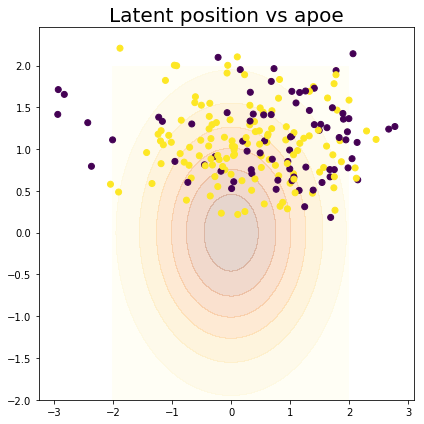

0.00049279517026

PVALUE for 0 apoe 0.0004927951702603831, 0.2926917170882225 vs 0.6769511063436144
0.016205399141

PVALUE for 1 apoe 0.01620539914100632, -0.030720467746257783 vs -0.08181397744307392
0.0956759459932

PVALUE for 2 apoe 0.09567594599319618, 1.0553294283151626 vs 1.1373190836686837
0.18304798007 2.20810127258


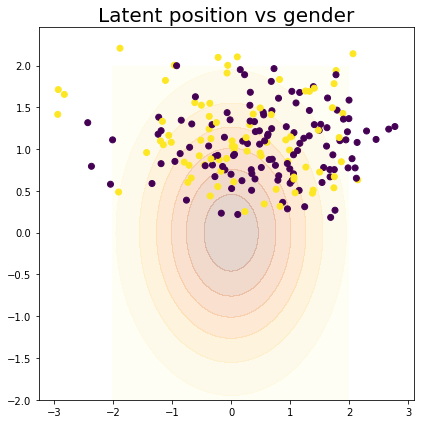

0.00338511158975

PVALUE for 0 gender 0.003385111589746963, 0.17787308736545285 vs 0.6172197945729023
0.272343813285
0.189533165437


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.433275282383 1.70399308205


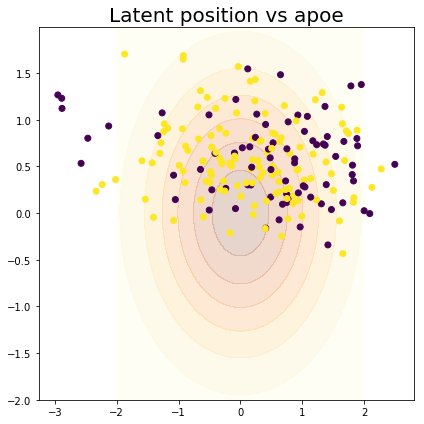

0.001528132407

PVALUE for 0 apoe 0.0015281324069951327, 0.13466073149442673 vs 0.4622755249668109
0.0919081228675

PVALUE for 1 apoe 0.09190812286745648, 0.016635595321655275 vs -0.012396971253972305
0.395959807677
-0.433275282383 1.70399308205


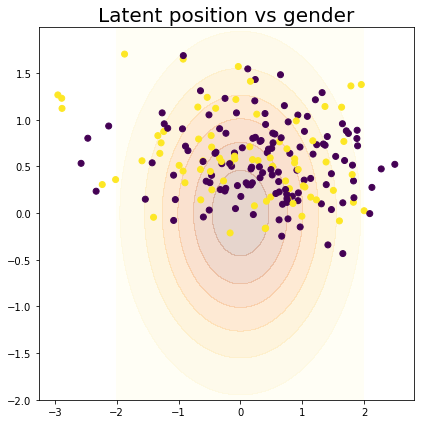

0.0234610874313

PVALUE for 0 gender 0.023461087431264998, 0.03823215782642365 vs 0.38966761505793013
0.411223192778
0.30846784007


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.902710735798 1.44166243076


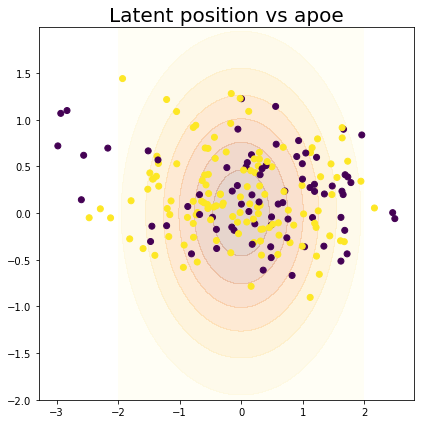

0.00242088262434

PVALUE for 0 apoe 0.002420882624336842, -0.06581768874199159 vs 0.2840609344375598
0.0953873787356

PVALUE for 1 apoe 0.09538737873562853, 0.010635785037471403 vs 0.029324190570162487
0.323578735018
-0.902710735798 1.44166243076


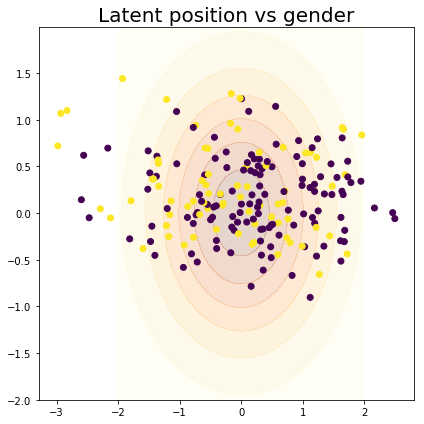

0.00536863531395

PVALUE for 0 gender 0.005368635313947055, -0.203320785065492 vs 0.2298441065682305
0.274926290593
0.0713933218442

PVALUE for 2 gender 0.07139332184420434, 0.26595330993334454 vs 0.14572000816937478


OUPS rid 729.0 65.65890502929688 vs 65.1
0.494066774845 2.46502828598


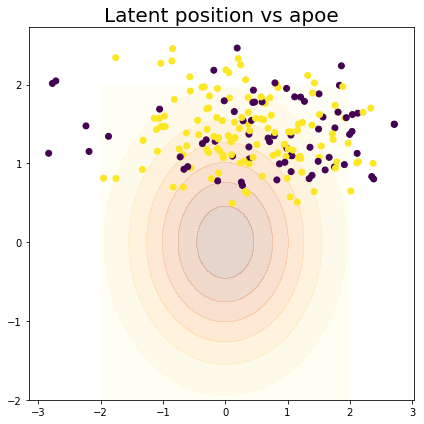

0.00234605397946

PVALUE for 0 apoe 0.002346053979459814, 0.3530525293487769 vs 0.6784916958758529
0.12237470787
0.352241486398
0.494066774845 2.46502828598


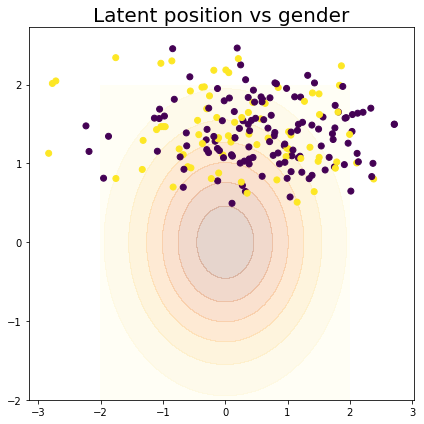

0.00319603705626

PVALUE for 0 gender 0.0031960370562631145, 0.18984063361820422 vs 0.6371348085403442
0.330379932042
0.317795087041


OUPS rid 729.0 65.65890502929688 vs 65.1
-0.76023375988 1.58381211758


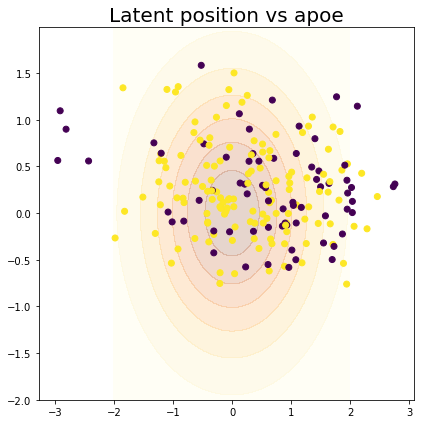

0.00271863800831

PVALUE for 0 apoe 0.0027186380083100725, 0.25512372770092706 vs 0.5997458277405172
0.0533954892819

PVALUE for 1 apoe 0.05339548928186795, 0.01465846925522342 vs 0.04892150345055953
0.431566226411
-0.76023375988 1.58381211758


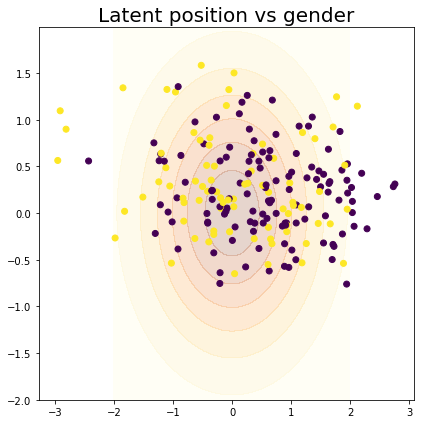

0.000175902803033

PVALUE for 0 gender 0.00017590280303345635, 0.013984133925619004 vs 0.6061807179548702
0.294604098941
0.20034527061
train: 0.07927702091990876 +/- 0.00011311955206735369 Test: 0.0859467271244253 +/- 0.0015859686694500487


In [15]:
train_errors = []
test_errors = []

for i in range(10):
    print('\n')
    output_dir = '../output_adas_variational/output_fold_new_time_{}'.format(i)

    model, train_dataset, test_dataset, train_residuals, test_residuals, train_lp, test_lp, _, _ = \
        load_output_dir(output_dir)

    #print('Train error {} test error {}'.format(np.mean(train_residuals), np.mean(test_residuals)))

    train_errors.append(np.mean(train_residuals))
    test_errors.append(np.mean(test_residuals))
    
    apoe_dataset = get_info_for_dataset(train_dataset, 'APOE4', conversion=lambda x:0 if int(x)==0 else 1)
    gender_dataset = get_info_for_dataset(train_dataset, 'PTGENDER', conversion=lambda x:0 if x == 'Male' else 1)
    first_visit_ages = get_info_for_dataset(train_dataset, 'AGE', conversion= lambda x:float(x))
    
    #train_lp[:, 0] = train_lp[:,0] / (model.mean_slope_norm.detach().numpy() + train_lp[:, 2]) * train_dataset.ages_std + train_dataset.ages_mean + first_visit_ages

    for (name, labels) in zip(["apoe", "gender"], [apoe_dataset, gender_dataset]):
            plt.figure(figsize=(6, 6))
            #plt.xlim(-3, 3)
            #plt.ylim(-3, 3)
            print(np.min(train_lp[:, -1]), np.max(train_lp[:, -1]))
            #plot_normal_density(-2, 2., -2., 2.)
            plt.scatter(train_lp[:, 0], train_lp[:, -1], c=labels) # one color by concept
            plt.title('Latent position vs {}'.format(name), fontsize=20)
            plt.tight_layout()
            plt.show()

            for i in range(model.encoder_dim):
                pval, mean_pos, mean_neg = mann_whitney_test(train_lp[:, i], labels)
                print(pval)
                if pval < pval_threshold:
                    print('\nPVALUE for {} {} {}, {} vs {}'.format(i, name, pval, mean_pos, mean_neg))
    
print("train: {} +/- {} Test: {} +/- {}".format(np.sqrt(np.mean(train_errors)), np.std(train_errors), np.sqrt(np.mean(test_errors)), np.std(test_errors)))

/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Dataset ages std 6.832847774104014 mean 76.27434832955552
-4.71847009659 1.14914512634
Dataset ages std 7.005042986082508 mean 76.20041157875163
-9.82726097107 2.24516487122
Dataset ages std 7.044997927791871 mean 75.92986227456392
-7.52160692215 1.48081970215
Dataset ages std 6.670158312764689 mean 76.33449608610567
-9.9160490036 2.46979522705
Dataset ages std 6.941467534915486 mean 76.54389490717294
-5.49858665466 1.56481075287
Dataset ages std 6.916229208684192 mean 76.32627232335167
-16.1498241425 2.46071338654
Dataset ages std 6.871598122975895 mean 75.95892398067538
-7.05977869034 1.80224323273
Dataset ages std 7.12223809273001 mean 76.00797314672865
-5.02046632767 1.65242624283
Dataset ages std 7.004963294475578 mean 75.96095212260953
-17.1871967316 2.8526058197
Dataset ages std 6.8375992683994475 mean 76.21880884687812
-8.23541355133 1.23916482925


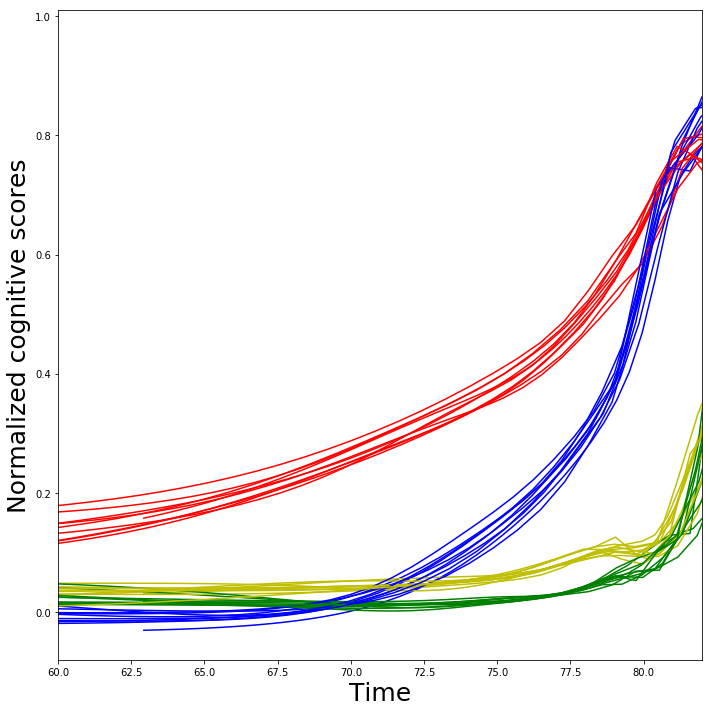

In [8]:
### For each fold, we get the model and compute the average trajectory.
trajectories = []
times = []
seen_times = []
parallel_trajectories = []

def x_to_time(x, model, dataset):
    return (x / np.exp(model.get_alpha_mean()) + model.get_time_shift_mean()) * dataset.ages_std + dataset.ages_mean

for fold_number in range(10):
    output_dir = "../output_adas_variational/output_fold_new_time_{}".format(fold_number)
    #output_dir = '../output_adas/output_randomized_nb_obs_fold_{}'.format(fold_number)
     
    model, train_dataset, _, _, _, train_lp, _, train_lt, _= load_output_dir(output_dir)
    print('Dataset ages std {} mean {}'.format(train_dataset.ages_std, train_dataset.ages_mean))
       
    min_x = np.min(train_lt[:, 0])
    max_x = np.max(train_lt[:, 0])
     
    print(min_x, max_x)
    x, trajectory = model.get_mean_trajectory(min_x, max_x)
    seen_times.append(x_to_time(train_lt[:,0], model, train_dataset))
    normalized_times = x_to_time(x.cpu().detach().numpy(), model, train_dataset)
    times.append(normalized_times)
    trajectories.append(trajectory.cpu().detach().numpy())
    
    parallel_trajs = []
    for i in range(1, model.latent_space_dim):
        orthogonal_direction = np.zeros(model.latent_space_dim)
        for val in [-1., 1.]:
            orthogonal_direction[i] = val
            x_np = np.linspace(min_x, max_x, 50)
            latent_np = np.zeros((len(x_np), model.latent_space_dim))
            latent_np[:, 0] = x_np
            latent_np = latent_np + orthogonal_direction
            latent_traj = torch.from_numpy(latent_np).type(model.type)
            scores_traj = model.decoder(latent_traj)
            parallel_trajs.append(scores_traj.cpu().detach().numpy())
    parallel_trajectories.append(parallel_trajs)
    
colors = ['b', 'g', 'r', 'c']

plt.figure(figsize=(10,10))
for (time, seen_time, traj) in zip(times, seen_times, trajectories):
    for i in range(4):
        plt.plot(time, traj[:, i], label=model.labels[i], c=model.colors[i])
        #plt.hist(seen_time, normed=True, alpha=0.2, bins=50)
    #plt.show()
        
#for (time, parallel_trajs) in zip(times, parallel_trajectories):
#    for parallel_traj in parallel_trajs:
#        for i in range(4):
#            plt.plot(time, parallel_traj[:, i], c=model.colors[i], linestyle='dotted', linewidth=0.5)
        
        
plt.xlim(60, 82)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Normalized cognitive scores', fontsize=25)
plt.tight_layout()
plt.savefig('../Figures/cognitive_scores_average_trajectory_variational.pdf', bbox_inches='tight', pad_inches=0)
plt.show()  

    

/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Percentage of predictions better than the last obs 0.2558139534883721 for 11
3.87945194025
Number of values for poteau 0.0 : 20
Number of values for poteau 0.6 : 17
Number of values for poteau 1.2 : 20
Number of values for poteau 1.8 : 1


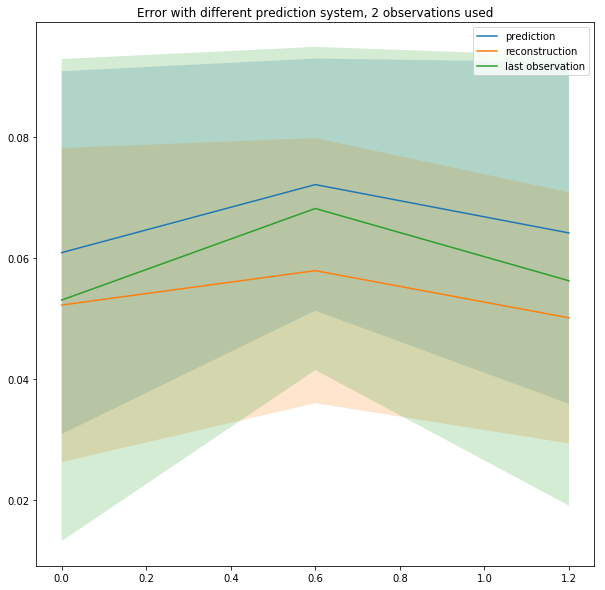

Percentage of predictions better than the last obs 0.6296296296296297 for 17
3.35616449371
Number of values for poteau 0.0 : 14
Number of values for poteau 0.6 : 21
Number of values for poteau 1.2 : 1


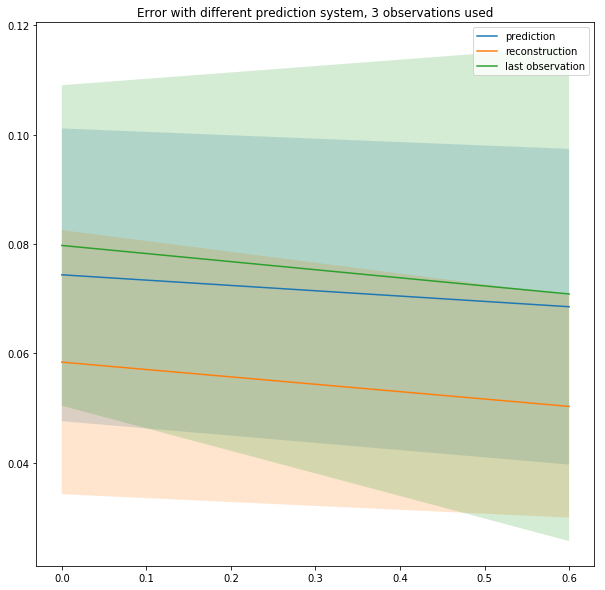

2.8575343916
Number of values for poteau 0.0 : 13
Number of values for poteau 0.6 : 7
Number of values for poteau 1.2 : 9
Number of values for poteau 1.8 : 1


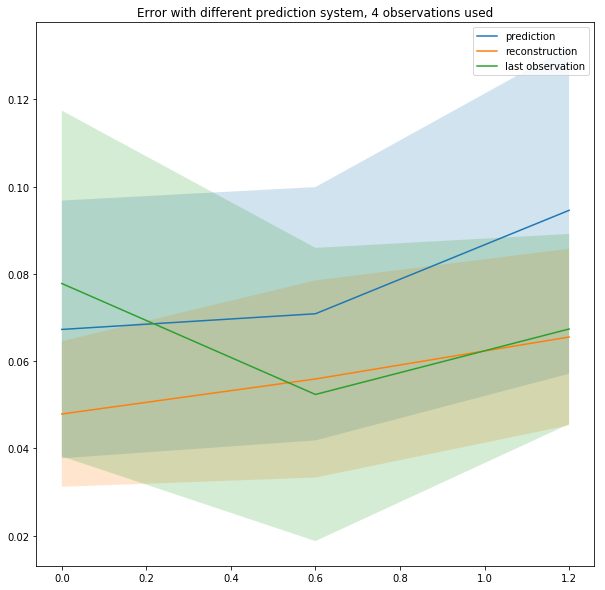

In [5]:
# Predicting the future:
fold_numbers = range(10)


for nb_obs_to_keep in range(2,5):
    n_pos = 0
    n_total = 0
    for fold_number in fold_numbers:
        output_dir = "../output_adas_variational/output_fold_{}".format(fold_number)
        output_dir = "../output_adas_variational/output_fold_new_time_{}".format(fold_number)
        #output_dir = "../output_adas/output_randomized_nb_obs_fold_{}".format(fold_number)
        
        model, train_dataset, test_dataset, _, _, _, _, _, _ = load_output_dir(output_dir)
        dataloader = DataLoader(test_dataset, batch_size=1)

        errors = {}
        for i in range(10):
            errors[i] = []

        itera = 0

        ages_prediction = []
        errors = {'prediction':[],'reconstruction':[],'linear regression':[],'last observation':[]}

        for data in dataloader:
            itera += 1
            times = data['times'].squeeze(0)
            values = data['values'].squeeze(0)
            obs_shape = values[0].cpu().detach().numpy().squeeze().shape

            nb_obs = len(values)

            if nb_obs > nb_obs_to_keep:
                times_for_pred = times[:nb_obs_to_keep]
                values_for_pred = values[:nb_obs_to_keep]
                values_target = values[nb_obs_to_keep:]
                times_target = times[nb_obs_to_keep:]

                # Prediction with only the beginning of the sequence
                means = model.encoder.get_sequence_output(times_for_pred, values_for_pred)
                latent_traj = model.get_latent_positions_sample_from_means_and_log_variances(means, times_target, None, sample=False)
                predictions = model.decoder(latent_traj).cpu().detach().numpy().reshape((len(latent_traj),) + obs_shape)

                # Prediction with the whole sequence               
                means_reconst = model.encoder.get_sequence_output(times, values)
                latent_traj_reconst = model.get_latent_positions_sample_from_means_and_log_variances(means_reconst, times_target, None, sample=False)
                reconstructions = model.decoder(latent_traj_reconst).cpu().detach().numpy()\
                    .reshape((len(latent_traj_reconst),) + obs_shape)

                # Numpy-ing the outputs
                times_for_pred = times_for_pred.cpu().detach().numpy()
                values_for_pred = values_for_pred.cpu().detach().numpy().reshape((len(values_for_pred),) + obs_shape)
                times_target = times_target.cpu().detach().numpy()
                values_target = values_target.cpu().detach().numpy().reshape((len(values_target),) + obs_shape)
                latent_traj = latent_traj.cpu().detach().numpy()
                latent_traj_reconst = latent_traj_reconst.cpu().detach().numpy()

                # Getting a linear prediction:
                linear_regression = LinearRegression()
                linear_regression.fit(times_for_pred, values_for_pred.reshape(len(values_for_pred), -1))
                predictions_linear_regression = linear_regression.predict(times_target).reshape((len(times_target),)+obs_shape)

                for i, (target, pred, reconstruction, pred_linear_regression) in \
                        enumerate(zip(values_target, predictions, reconstructions, predictions_linear_regression)):
                    time_since_last_observation = float(times_target[i] - times_for_pred[-1]) * train_dataset.ages_std

                    
                    
                    error = mean_absolute_error(pred, target)
                    error_reconst = mean_absolute_error(reconstruction, target)
                    error_last_obs = mean_absolute_error(values_for_pred[-1], target)
                    error_linear_regression = mean_absolute_error(pred_linear_regression, target)
                    images = [pred.squeeze(), reconstruction.squeeze(), pred_linear_regression.squeeze(), target.squeeze()]

                    if 3. < time_since_last_observation:
                        n_total += 1
                        if error <= error_last_obs:
                            n_pos += 1
                    
                    errors['prediction'].append(error)
                    errors['reconstruction'].append(error_reconst)
                    errors['linear regression'].append(error_linear_regression)
                    errors['last observation'].append(error_last_obs)
                    ages_prediction.append(time_since_last_observation)
    if n_total > 0:
        print('Percentage of predictions better than the last obs {} for {}'.format(n_pos*1/n_total, n_pos))

    # We gather the errors in bins:
    n_bins = 8
    print(max(ages_prediction))
    poteaux = np.linspace(min(ages_prediction), max(ages_prediction), n_bins)
    poteaux = np.array([0., 0.6, 1.2, 1.8, 2.4, 3.])
    errors_by_poteau = []

    stds = {'prediction':[], 'reconstruction':[], 'linear regression':[], 'last observation':[]}
    means = {'prediction':[], 'reconstruction':[], 'linear regression':[], 'last observation':[]}

    for i in range(len(poteaux)-1):
        left = poteaux[i]
        right = poteaux[i+1]
        gathered_errors = {'prediction':[], 'reconstruction':[], 'linear regression':[], 'last observation':[]}
        for j, age in enumerate(ages_prediction):
            if age >= left and age < right:
                for key in errors.keys():
                    gathered_errors[key].append(errors[key][j])
        print('Number of values for poteau {} : {}'.format(poteaux[i], len(gathered_errors['prediction'])))
        if len(gathered_errors['prediction']) > 5:
            for key in gathered_errors.keys():
                stds[key].append(np.std(gathered_errors[key]))
                means[key].append(np.mean(gathered_errors[key]))
        else:
            break


    plt.figure(figsize=(10,10))
    for key in stds.keys():
        stds[key] = np.array(stds[key])
        means[key] = np.array(means[key])
        if key != 'linear regression':
            plt.plot(poteaux[:len(means[key])], means[key], label=key)
            plt.fill_between(poteaux[:len(means[key])], means[key]-stds[key], means[key]+stds[key], alpha=0.2)
    plt.title('Error with different prediction system, {} observations used'.format(nb_obs_to_keep))
    plt.legend()
    plt.show()


In [6]:
# Looking at the prior parameters
fold_numbers = range(10)

time_shift_means = []
alpha_means = []

for fold_number in fold_numbers:
    output_dir = "../output_adas_variational/output_fold_new_time_{}".format(fold_number)

    model, _, _, _, _, _, _, _, _ = load_output_dir(output_dir)

    time_shift_means.append(model.get_time_shift_mean())
    alpha_means.append(np.exp(model.get_alpha_mean()))

print('Time shift mean {} +/- {}, Alphas mean {} +/- {}'\
      .format(np.mean(time_shift_means), np.std(time_shift_means),\
             np.mean(alpha_means), np.std(alpha_means)))



/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Time shift mean 0.33524683117866516 +/- 0.12267277389764786, Alphas mean 2.2087161540985107 +/- 0.8407106399536133
